In [1]:
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GRNfer

from bengrn import BenGRN, get_sroy_gt, FILEDIR
import scanpy as sc
from bengrn.base import train_classifier

from anndata.utils import make_index_unique
from bengrn import compute_genie3
from grnndata import utils as grnutils

import numpy as np

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_types.py:9: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.i

In [2]:
# '../../data/main/gene_embeddings.parquet')
model = scPrint.load_from_checkpoint(
    '../../data/temp/wli32e2j/last.ckpt', precpt_gene_emb=None)
#model = scPrint.load_from_checkpoint(
#    '../../data/temp/25eer0xz/epoch=20-step=105000.ckpt', precpt_gene_emb=None)
MAXGENES = 5000

RuntimeError caught: scPrint is not attached to a `Trainer`.



In [ ]:
# zhao
Better to transpose except for the max of all
# tran
Better to transpose except for the max of all
# han

# my data
0.031 - 1.12 (medium - not transpose)
0.040 - 1.51 (medium - not transpose, using 0.1, 200-1, 100iter, omni)
0.037 - 1.76 (medium - not transpose, using 0.2, 40-1 , self)

can reach 0.072 but by leveraging the fact that we have low definitions in the auprc
omnipath seems to prefer tranposing


# sROY data

In [3]:
preprocessor = Preprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)

In [4]:
preadata = get_sroy_gt(get="han", species="human", gt="full")

adata = preprocessor(preadata.copy())
adata.var["isTF"] = False

adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 5520 renamining
filtered out 0 cells, 5520 renamining
Removed 0 genes.
startin QC
Seeing 151 outliers (2.74% of total dataset):
done


(GRnnData object with n_obs × n_vars = 5520 × 7465
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 8463 elements,
 31)

In [5]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=1024,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.varp['all'] = grn.varp['GRN']
grn.var['ensembl_id']= grn.var.index
grn.var.index = make_index_unique(grn.var['symbol'].astype(str))

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 7295


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [1]:
grn.varp['GRN'] = grn.varp['all'][:,:,:].max(-1)
grn.varp['GRN'][grn.var.TFs] = 0
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

NameError: name 'grn' is not defined

precision:  0.033927736592533224 
recall:  0.16893914200199533 
random precision: 0.027391145928220076


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:721: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1975.77it/s]


Area Under Precision-Recall Curve (AUPRC):  0.030162978799941377
EPR: 0.9313924448741395


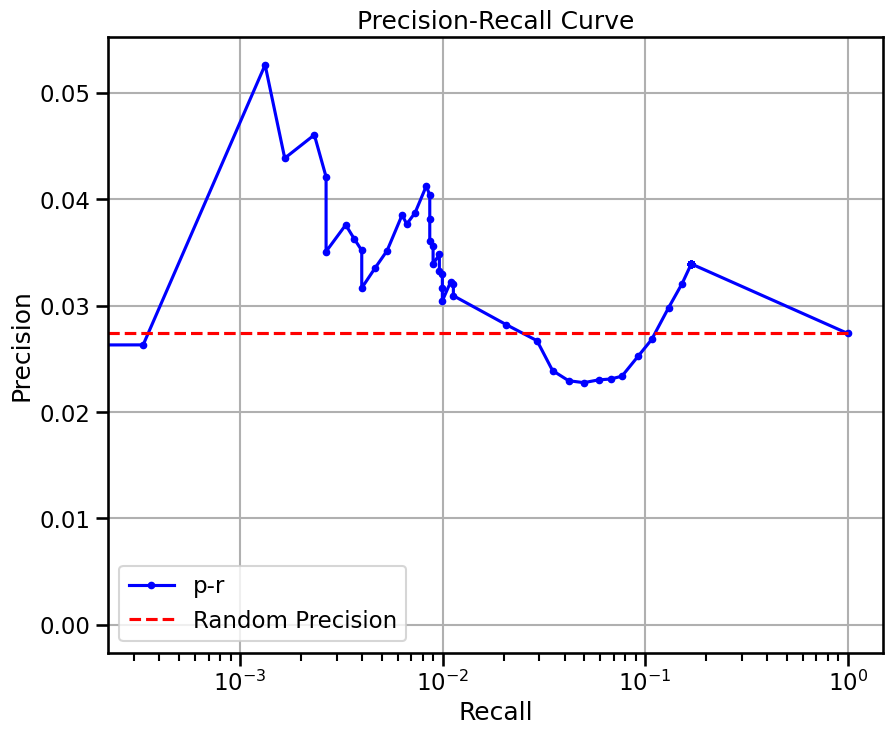

{'precision': 0.033927736592533224,
 'recall': 0.16893914200199533,
 'rand_precision': 0.027391145928220076,
 'auprc': 0.030162978799941377,
 'epr': 0.9313924448741395}

In [32]:
grn.varp['GRN'] = grn.varp['all'][:,:,:].max(-1)
grn.varp['GRN'][grn.var.TFs] = 0
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.027385657820440428 
recall:  1.0 
random precision: 0.027391145928220076


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:721: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 2010.82it/s]


Area Under Precision-Recall Curve (AUPRC):  0.02953346732556008
EPR: 1.1635722729365414


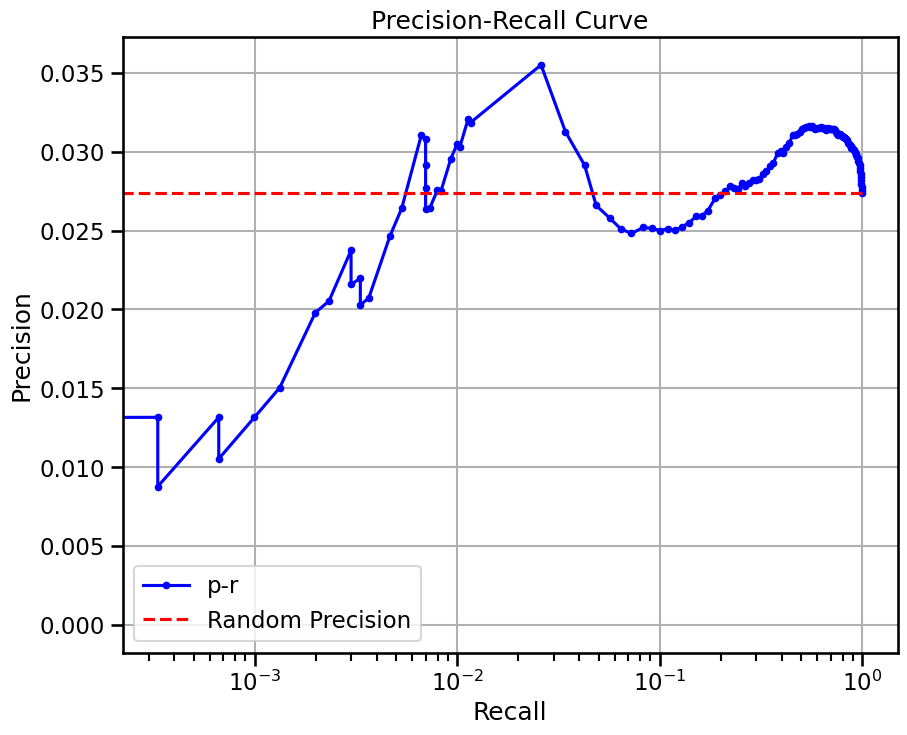

{'precision': 0.027385657820440428,
 'recall': 1.0,
 'rand_precision': 0.027391145928220076,
 'auprc': 0.02953346732556008,
 'epr': 1.1635722729365414}

In [18]:
grn.varp['GRN'] = grn.varp['all'][:,:,:].max(-1).T
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.027385657820440428 
recall:  1.0 
random precision: 0.027391145928220076


 99%|█████████▉| 98/99 [00:00<00:00, 977.03it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:720: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 946.35it/s]


Area Under Precision-Recall Curve (AUPRC):  0.03158862654613999
EPR: 1.3748181669897135


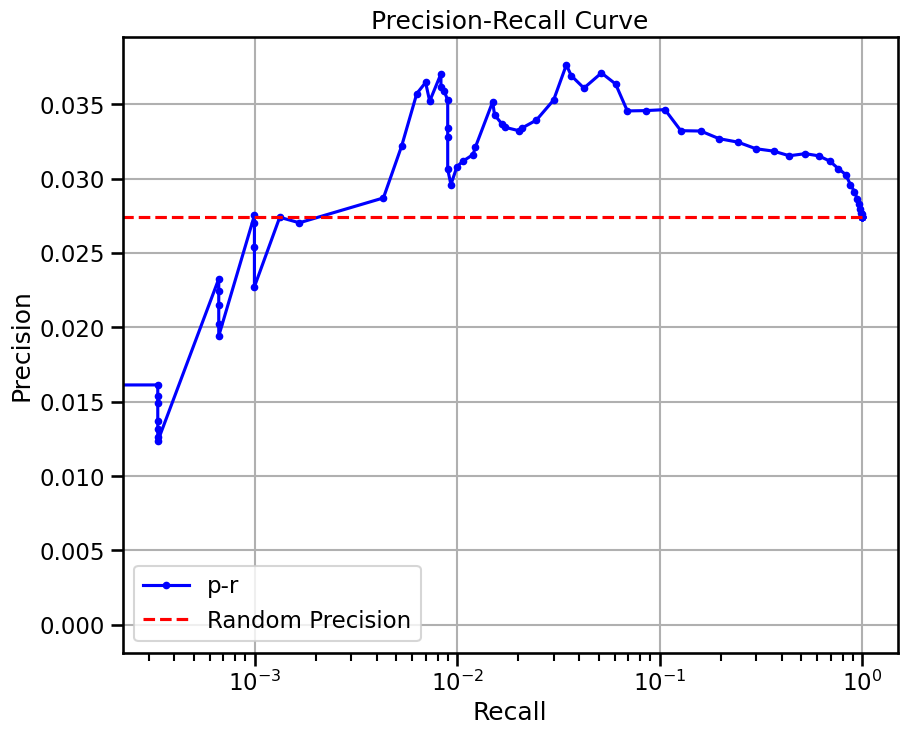

{'precision': 0.027385657820440428,
 'recall': 1.0,
 'rand_precision': 0.027391145928220076,
 'auprc': 0.03158862654613999,
 'epr': 1.3748181669897135}

In [11]:
grn.var['ensembl_id']= grn.var.index
grn.var.index = make_index_unique(grn.var['symbol'].astype(str))
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['all'].mean(-1)
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.027385657820440428 
recall:  1.0 
random precision: 0.027391145928220076


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:720: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 1504.78it/s]


Area Under Precision-Recall Curve (AUPRC):  0.026460253031124193
EPR: 0.35135343421725335


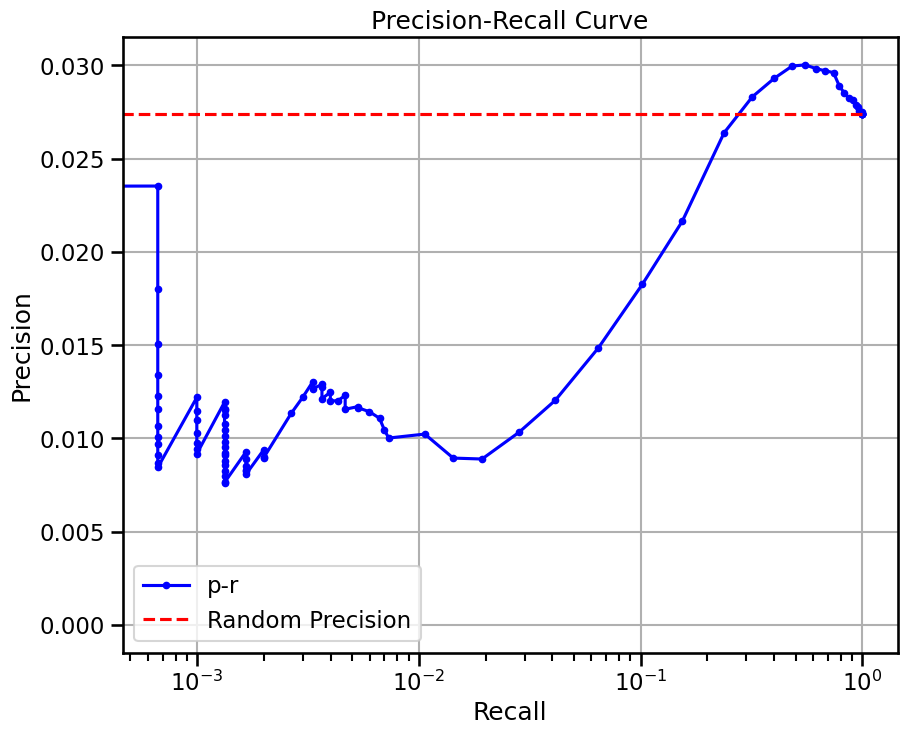

{'precision': 0.027385657820440428,
 'recall': 1.0,
 'rand_precision': 0.027391145928220076,
 'auprc': 0.026460253031124193,
 'epr': 0.35135343421725335}

In [12]:
grn.varp['GRN'] = grn.varp['all'].mean(-1).T
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

true elem 21456 ...
doing classification....
metrics {'used_heads': 22, 'precision': 0.006971340046475601, 'random_precision': 0.001511764501786856, 'recall': 0.008430913348946136, 'predicted_true': 2582.0, 'number_of_true': 2135.0, 'epr': 5.017202723911236}


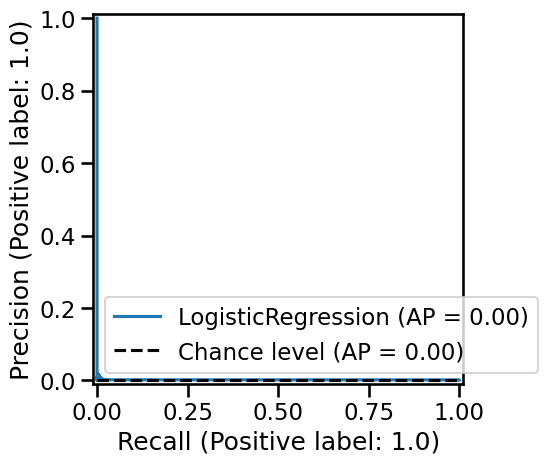

precision:  0.027385657820440428 
recall:  1.0 
random precision: 0.027391145928220076


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:720: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 1123.50it/s]


Area Under Precision-Recall Curve (AUPRC):  0.035564620394229404
EPR: 1.348157935722073


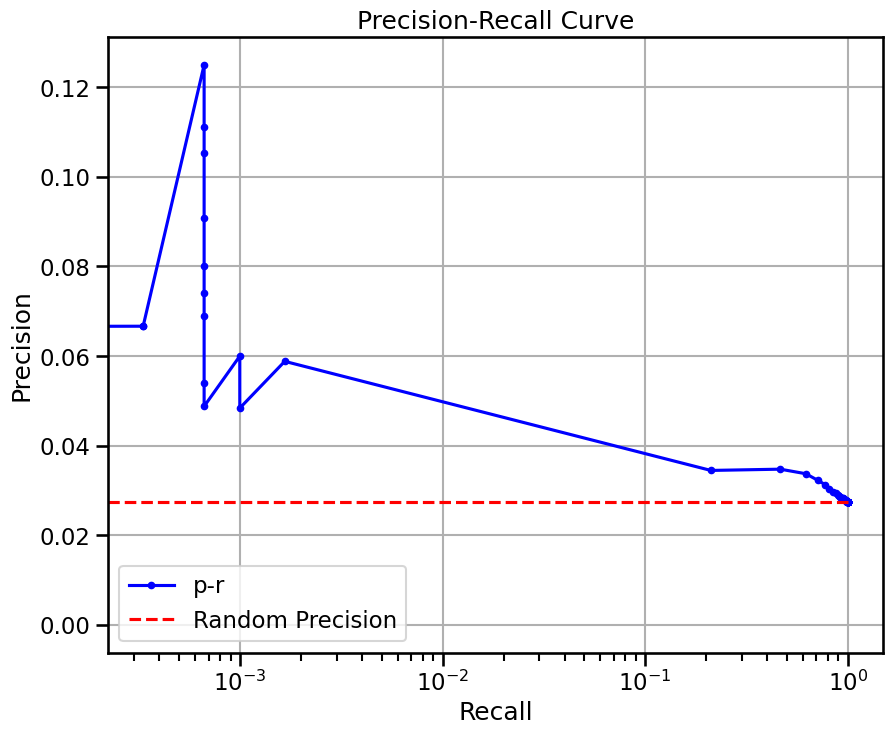

{'precision': 0.027385657820440428,
 'recall': 1.0,
 'rand_precision': 0.027391145928220076,
 'auprc': 0.035564620394229404,
 'epr': 1.348157935722073}

In [26]:
grn.varp['GRN'] = grn.varp['all']
del grn.varp['all']
grn, m, clf_omni = train_classifier(grn, C=0.1, train_size=0.9, class_weight={
                                    1: 200, 0: 1}, shuffle=True, max_iter=1000)
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [31]:
grn.varp['GRN'] = np.transpose(grn.varp['all'],(1,0,2))
del grn.varp['all']
grn, m, clf_omni = train_classifier(grn, C=0.1, train_size=0.9, class_weight={
                                    1: 2_000, 0: 1}, shuffle=True, max_iter=1000)
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

true elem 21456 ...
 21456 ...
doing classification....


# new data

In [3]:
import scanpy as sc
import pandas as pd
from grnndata import from_adata_and_longform
from scdataloader import Preprocessor

preprocessor = Preprocessor(is_symbol=False, force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=MAXGENES, min_dataset_size=64)

#https://www.ebi.ac.uk/gxa/sc/experiments/E-GEOD-36552/downloads
data = sc.read_mtx(FILEDIR+'/../data/GroundTruth/stone_and_sroy/scRNA/E-GEOD-36552.aggregated_filtered_counts.mtx').T
col = pd.read_csv(FILEDIR+'/../data/GroundTruth/stone_and_sroy/scRNA/E-GEOD-36552.aggregated_filtered_counts.mtx_rows', header=None, sep='\t')
data.var.index = col[0]
data.obs['organism_ontology_term_id'] = "NCBITaxon:9606"

df = pd.read_csv(
    FILEDIR + "/../data/GroundTruth/stone_and_sroy/hESC_ground_truth.tsv",
    sep="\t",
    header=None,
)

data = preprocessor(data.copy())

data.var["isTF"] = False
data.var.loc[data.var.symbol.isin(grnutils.TF), "isTF"] = True

data.var['ensembl_id'] = data.var.index
data.var.index = data.var['symbol']
preadata = from_adata_and_longform(data, df)
preadata.var.index = preadata.var['ensembl_id']
data.var.index = data.var['ensembl_id']

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
 KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 115 renamining
filtered out 0 cells, 115 renamining
Removed 83 genes.
startin QC
Seeing 104 outliers (90.43% of total dataset):
done


In [4]:
grn_inferer = GRNfer(model, data,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=data.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=1024,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 28398


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [5]:
grn.varp['all'] = grn.varp['GRN'].copy()

pred shape (18, 4143, 32)
true elem 2354 ...
doing classification....
metrics {'used_heads': 2, 'precision': 0.030117735403760025, 'random_precision': 0.030117735403760025, 'recall': 1.0, 'predicted_true': 37287.0, 'number_of_true': 1123.0, 'epr': 1.391466201810628}


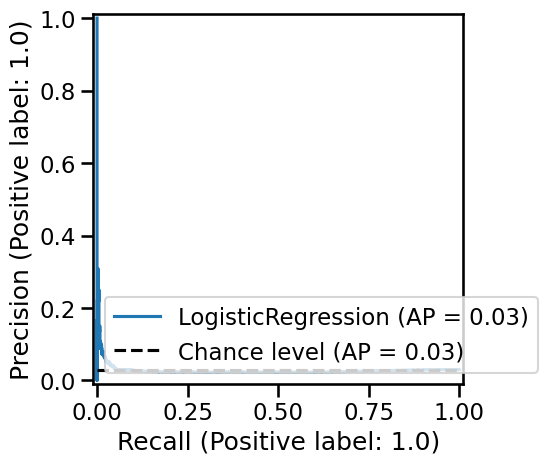

precision:  0.03156596132700405 
recall:  1.0 
random precision: 0.031573582273727134


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:721: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1978.45it/s]


Area Under Precision-Recall Curve (AUPRC):  0.03743980633057954
EPR: 1.760436523247433


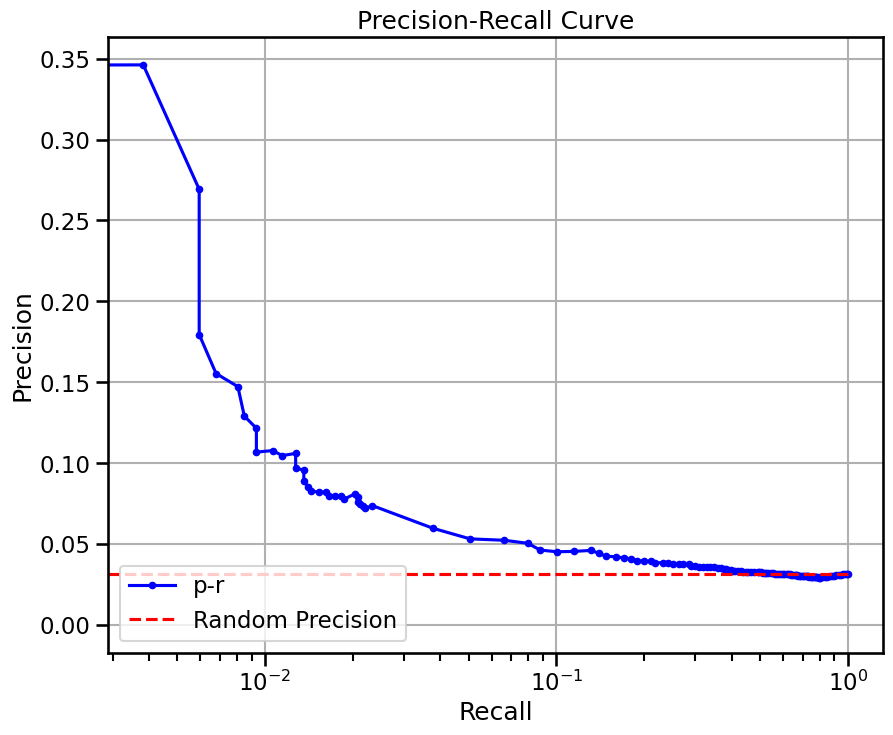

{'precision': 0.03156596132700405,
 'recall': 1.0,
 'rand_precision': 0.031573582273727134,
 'auprc': 0.03743980633057954,
 'epr': 1.760436523247433}

In [6]:
grn.varp['GRN'] = grn.varp['all']
del grn.varp['all']
#grn.var.index = grn.var['ensembl_id']
grn, m, clf_self = train_classifier(
    grn, other=preadata, C=0.2, train_size=0.5, class_weight={1: 40, 0: 1}, shuffle=False, use_col="ensembl_id")
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
#grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

true elem 10610 ...
doing classification....


metrics {'used_heads': 24, 'precision': 0.003050640634533252, 'random_precision': 0.0015433320142461417, 'recall': 0.009157509157509158, 'predicted_true': 3278.0, 'number_of_true': 1092.0, 'epr': 4.80238558843153}


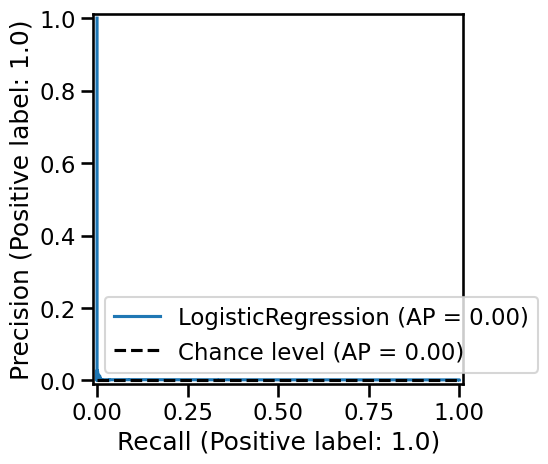

precision:  0.03156596132700405 
recall:  1.0 
random precision: 0.031573582273727134


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:721: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 2482.94it/s]


Area Under Precision-Recall Curve (AUPRC):  0.04085337593677105
EPR: 1.5129514238520643


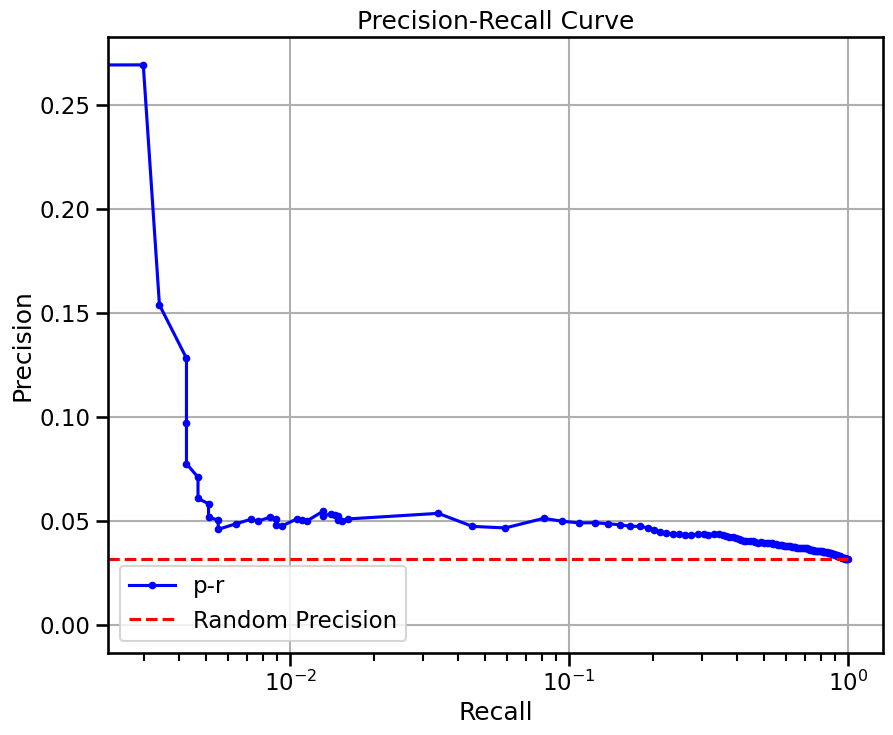

{'precision': 0.03156596132700405,
 'recall': 1.0,
 'rand_precision': 0.031573582273727134,
 'auprc': 0.04085337593677105,
 'epr': 1.5129514238520643}

In [7]:
grn.varp['GRN'] = grn.varp['all']
del grn.varp['all']
grn, m, clf_omni = train_classifier(grn, C=0.1, train_size=0.9, class_weight={
                                    1: 200, 0: 1}, shuffle=True, max_iter=100)
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.03156596132700405 
recall:  1.0 
random precision: 0.031573582273727134


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:720: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 1564.77it/s]


Area Under Precision-Recall Curve (AUPRC):  0.03318340159088609
EPR: 1.3020731985245777


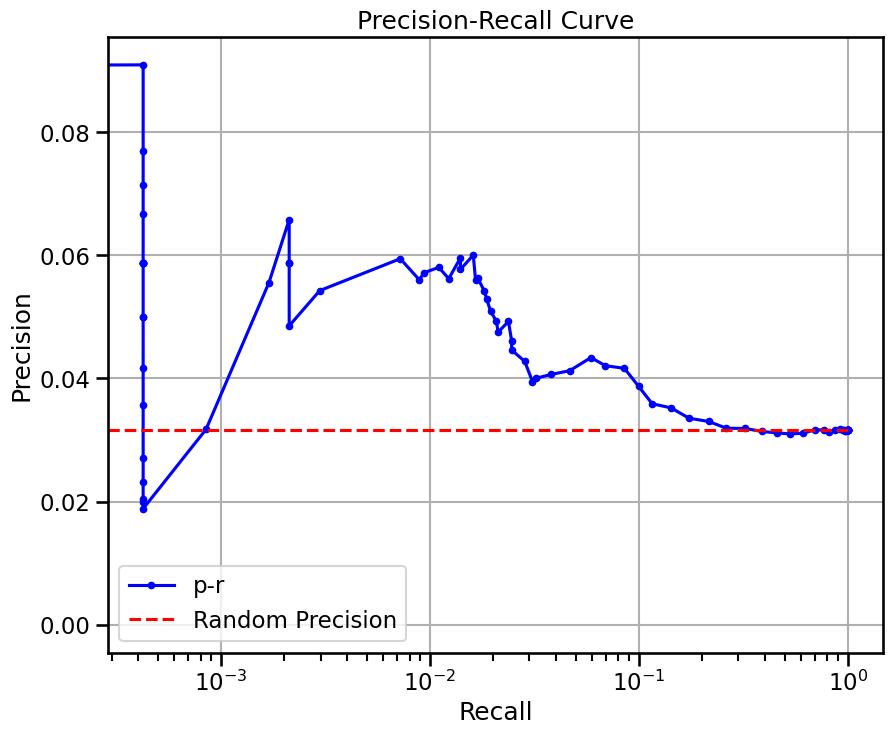

{'precision': 0.03156596132700405,
 'recall': 1.0,
 'rand_precision': 0.031573582273727134,
 'auprc': 0.03318340159088609,
 'epr': 1.3020731985245777}

In [ ]:
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['all'].mean(-1)
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

## omni classifier

precision:  0.03156596132700405 
recall:  1.0 
random precision: 0.031573582273727134


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:720: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 1244.78it/s]


Area Under Precision-Recall Curve (AUPRC):  0.029702731355997432
EPR: 0.24347362773913403


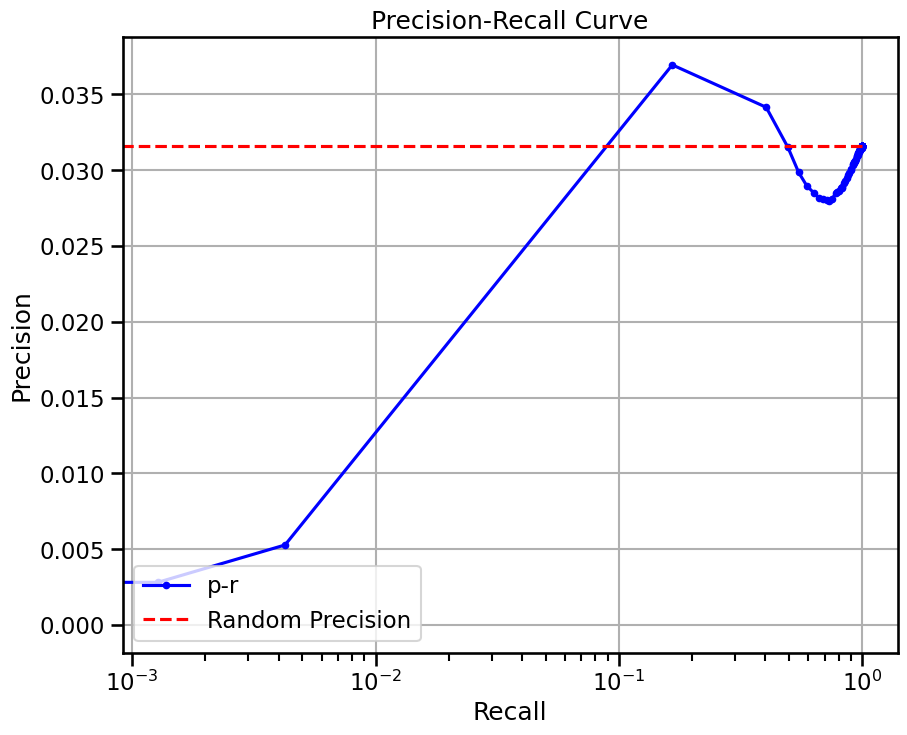

{'precision': 0.03156596132700405,
 'recall': 1.0,
 'rand_precision': 0.031573582273727134,
 'auprc': 0.029702731355997432,
 'epr': 0.24347362773913403}

In [ ]:
grn.varp['GRN'] = grn.varp['all']
del grn.varp['all']
grn, m, clf_omni = train_classifier(grn, C=0.1, train_size=0.9, class_weight={
                                    1: 200, 0: 1}, shuffle=True, max_iter=1000)
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)


precision:  0.03156596132700405 
recall:  1.0 
random precision: 0.031573582273727134


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:720: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 1312.78it/s]


Area Under Precision-Recall Curve (AUPRC):  0.036988269988886054
EPR: 0.7691281003775692


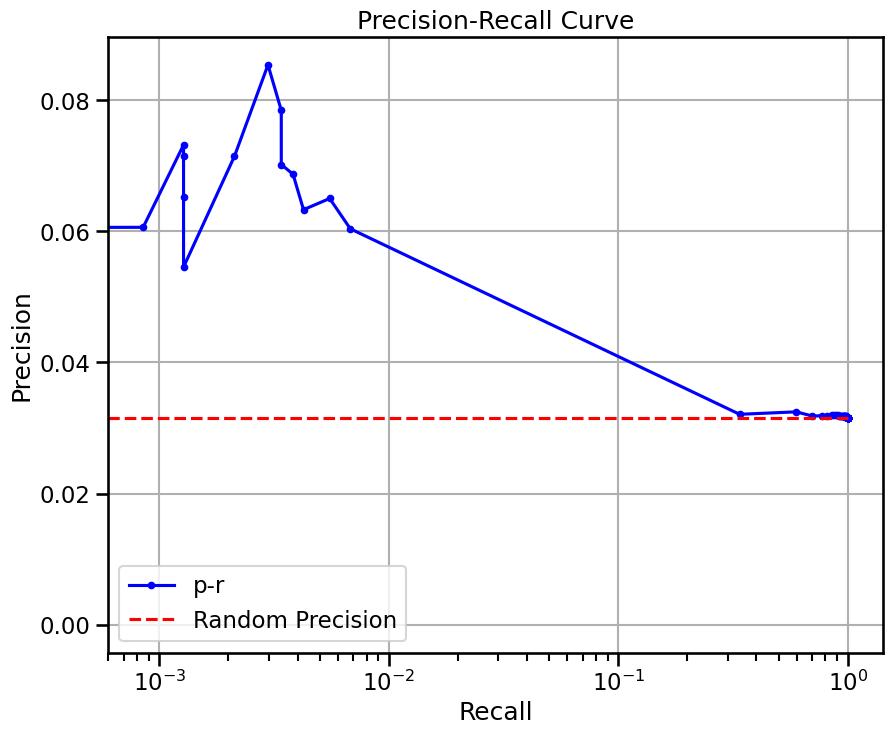

{'precision': 0.03156596132700405,
 'recall': 1.0,
 'rand_precision': 0.031573582273727134,
 'auprc': 0.036988269988886054,
 'epr': 0.7691281003775692}

In [ ]:
grn.varp['GRN'] = np.transpose(grn.varp['all'], (1,0,2))
del grn.varp['all']
grn, m, clf_omni = train_classifier(grn, C=0.1, train_size=0.9, class_weight={
                                    1: 200, 0: 1}, shuffle=True, max_iter=1000)
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

## self classifier

pred shape (18, 4143, 96)
true elem 2354 ...
doing classification....
metrics {'used_heads': 13, 'precision': 0.030117735403760025, 'random_precision': 0.030117735403760025, 'recall': 1.0, 'predicted_true': 37287.0, 'number_of_true': 1123.0, 'epr': 1.1643019566727033}


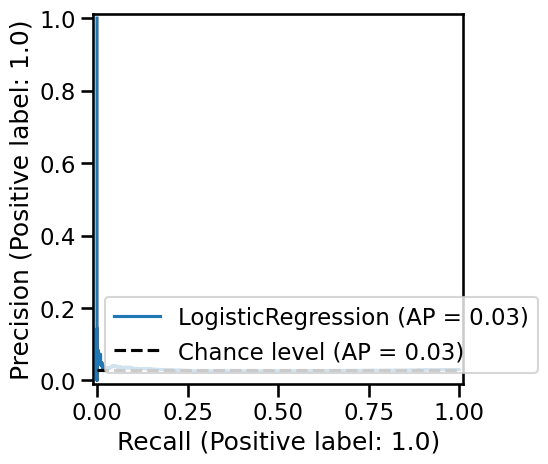

precision:  0.03156596132700405 
recall:  1.0 
random precision: 0.031573582273727134


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:720: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 1257.07it/s]


Area Under Precision-Recall Curve (AUPRC):  0.05866877665735067
EPR: 1.4219363682778037


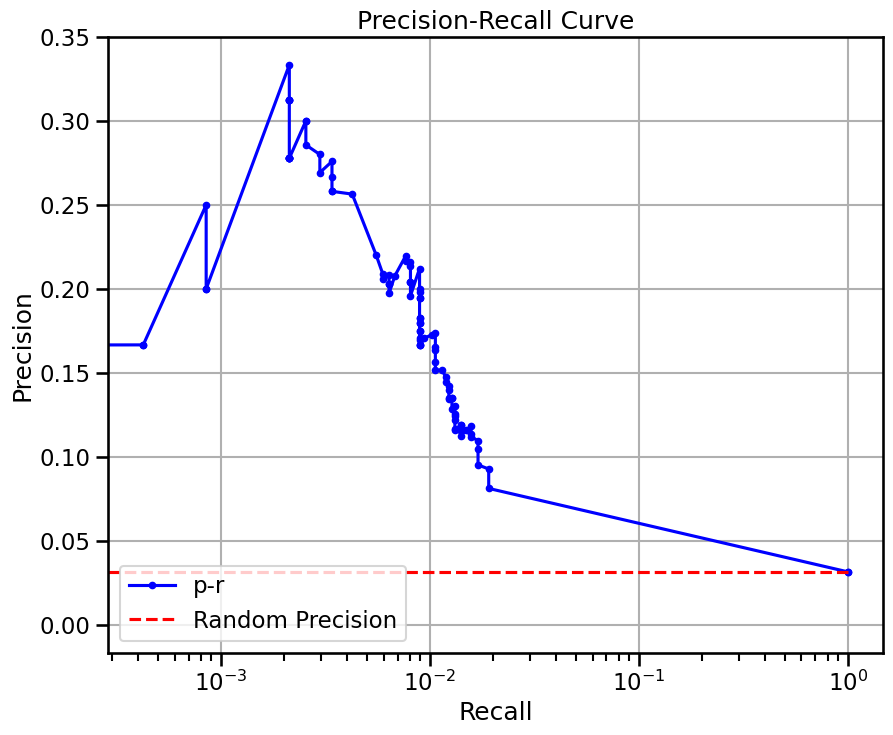

{'precision': 0.03156596132700405,
 'recall': 1.0,
 'rand_precision': 0.031573582273727134,
 'auprc': 0.05866877665735067,
 'epr': 1.4219363682778037}

In [ ]:
grn.varp['GRN'] = grn.varp['all']
#grn.var.index = grn.var['ensembl_id']
grn, m, clf_self = train_classifier(
    grn, other=preadata, C=0.1, train_size=0.5, class_weight={1: 40, 0: 1}, shuffle=False, use_col="ensembl_id") # 40, 1, 0.1
grn.varp['GRN'] = grn.varp['classified']
#grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

pred shape (18, 4143, 96)
true elem 2354 ...
doing classification....
metrics {'used_heads': 6, 'precision': 0.03594604695409914, 'random_precision': 0.030117735403760025, 'recall': 0.9421193232413179, 'predicted_true': 29433.0, 'number_of_true': 1123.0, 'epr': 3.936494247510758}


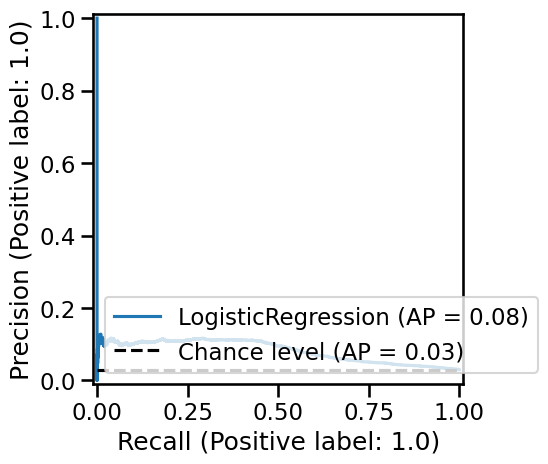

precision:  0.03156596132700405 
recall:  1.0 
random precision: 0.031573582273727134


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:720: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 2130.54it/s]


Area Under Precision-Recall Curve (AUPRC):  0.07233642394083216
EPR: 2.930178420910475


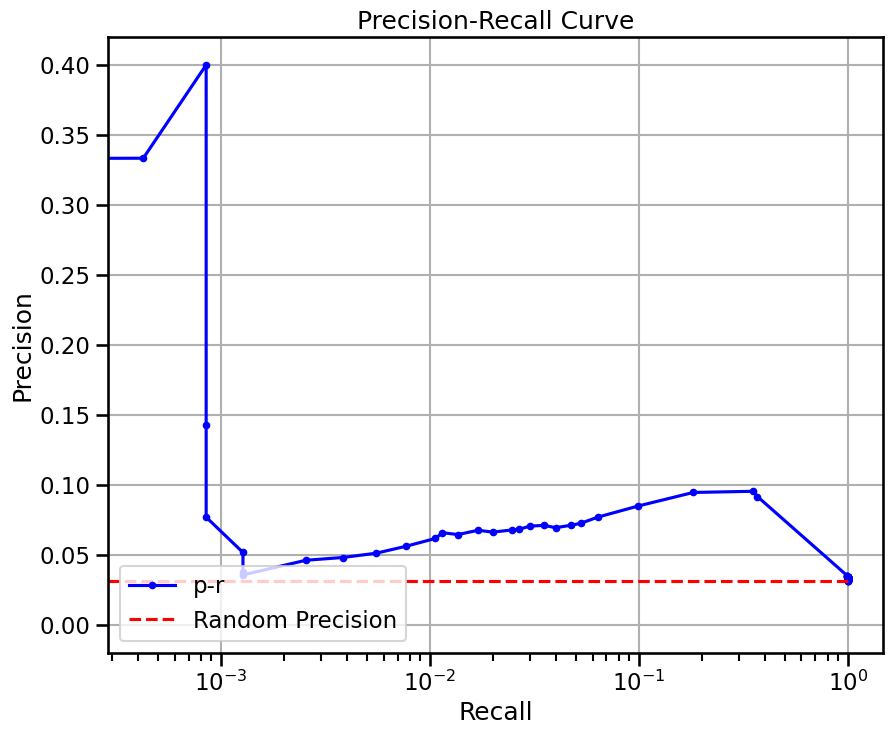

{'precision': 0.03156596132700405,
 'recall': 1.0,
 'rand_precision': 0.031573582273727134,
 'auprc': 0.07233642394083216,
 'epr': 2.930178420910475}

In [ ]:
grn.varp['GRN'] = np.transpose(grn.varp['all'], (1,0,2))
del grn.varp['all']
#grn.var.index = grn.var['ensembl_id']
grn, m, clf_self = train_classifier(
    grn, other=preadata, C=0.1, train_size=0.5, class_weight={1: 40, 0: 1}, shuffle=False, use_col="ensembl_id")
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
#grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

# testing the two new mouse dataset

In [ ]:
import joblib

clf_omni = joblib.load('clf_omni.pkl')
clf_self = joblib.load('clf_self.pkl')

In [8]:
preprocessor = Preprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)

In [34]:
preadata = get_sroy_gt(get="zhao", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 36199 renamining
filtered out 0 cells, 36199 renamining
Removed 0 genes.
startin QC
Seeing 828 outliers (2.29% of total dataset):
done


(GRnnData object with n_obs × n_vars = 36199 × 8442
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 9019 elements,
 34)

precision:  0.051739843323009654 
recall:  1.0 
random precision: 0.05175021410739992


 73%|███████▎  | 93/128 [00:00<00:00, 925.87it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:721: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1004.03it/s]


Area Under Precision-Recall Curve (AUPRC):  0.06913422478105277
EPR: 1.0381999805130386


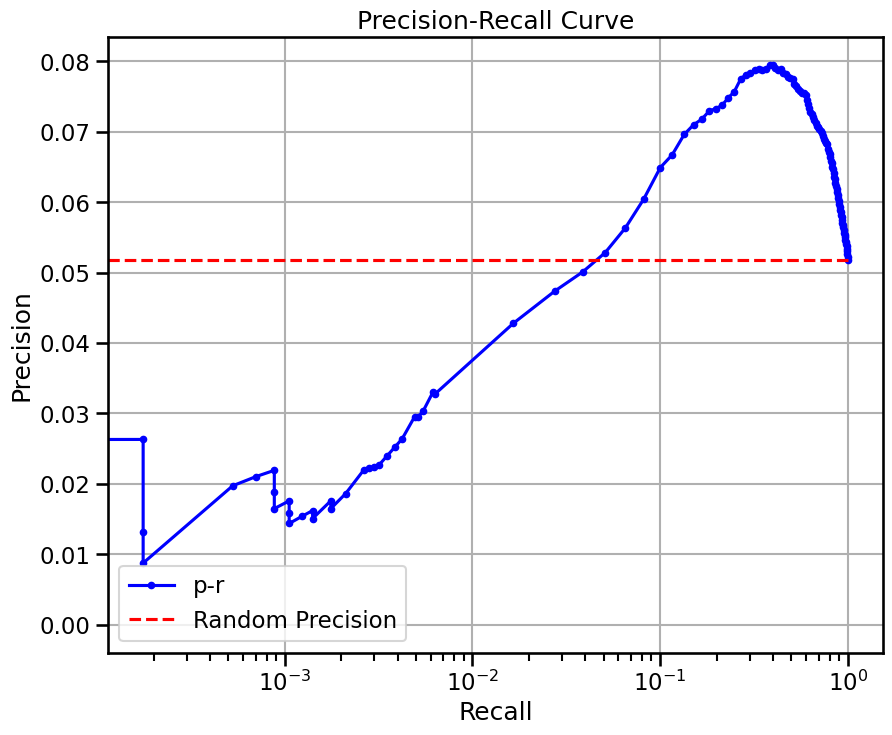

{'precision': 0.051739843323009654,
 'recall': 1.0,
 'rand_precision': 0.05175021410739992,
 'auprc': 0.06913422478105277,
 'epr': 1.0381999805130386}

In [58]:
grn.varp["GRN"] = clf_omni.predict_proba(
                    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
                ).reshape(len(grn.var), len(grn.var), 2)[:, :, 1].T
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.040534915985817786 
recall:  1.0 
random precision: 0.0405430408437023


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:721: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1591.34it/s]


Area Under Precision-Recall Curve (AUPRC):  0.03861175455203213
EPR: 1.2534234969638978


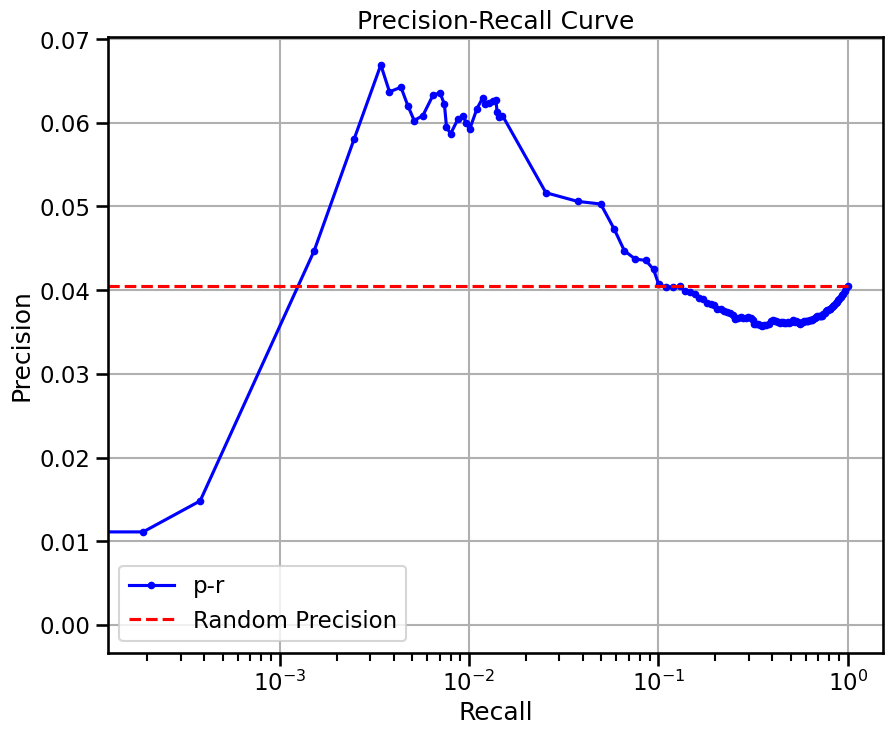

{'precision': 0.040534915985817786,
 'recall': 1.0,
 'rand_precision': 0.0405430408437023,
 'auprc': 0.03861175455203213,
 'epr': 1.2534234969638978}

In [33]:
grn.varp['GRN'] = grn.varp['all'][:,:,:].max(-1)
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)


precision:  0.051739843323009654 
recall:  1.0 
random precision: 0.05175021410739992


 82%|████████▏ | 105/128 [00:00<00:00, 1047.12it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:721: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1060.71it/s]


Area Under Precision-Recall Curve (AUPRC):  0.06037440391158652
EPR: 1.5167317658560544


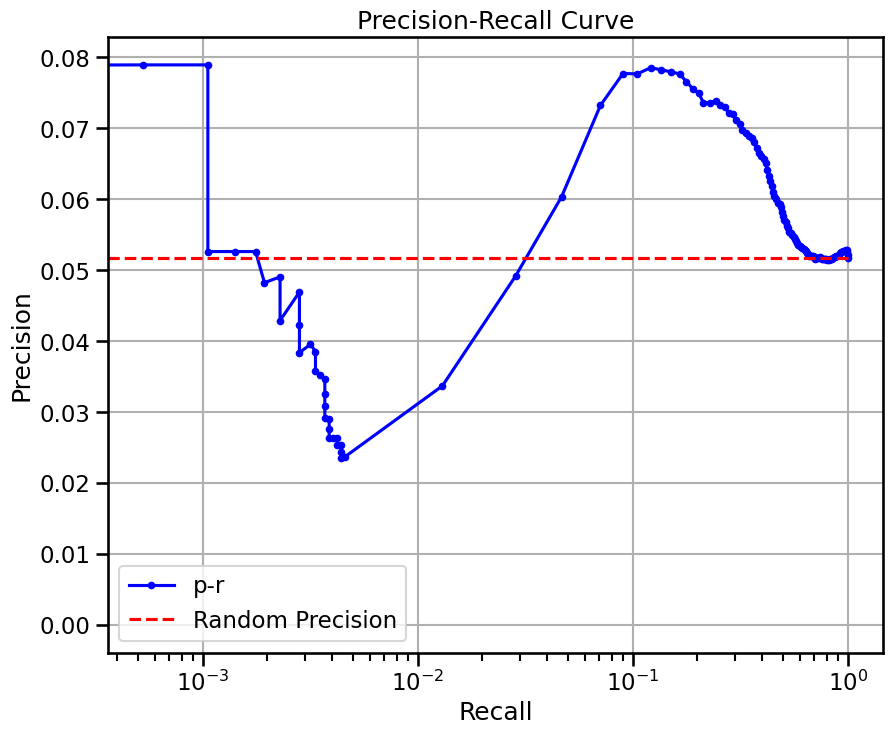

{'precision': 0.051739843323009654,
 'recall': 1.0,
 'rand_precision': 0.05175021410739992,
 'auprc': 0.06037440391158652,
 'epr': 1.5167317658560544}

In [48]:
grn.varp['GRN'] = grn.varp['all'][:,:,-4:].mean(-1).T
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.051739843323009654 
recall:  1.0 
random precision: 0.05175021410739992


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:721: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1313.53it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0540876874680279
EPR: 1.1382737356974408


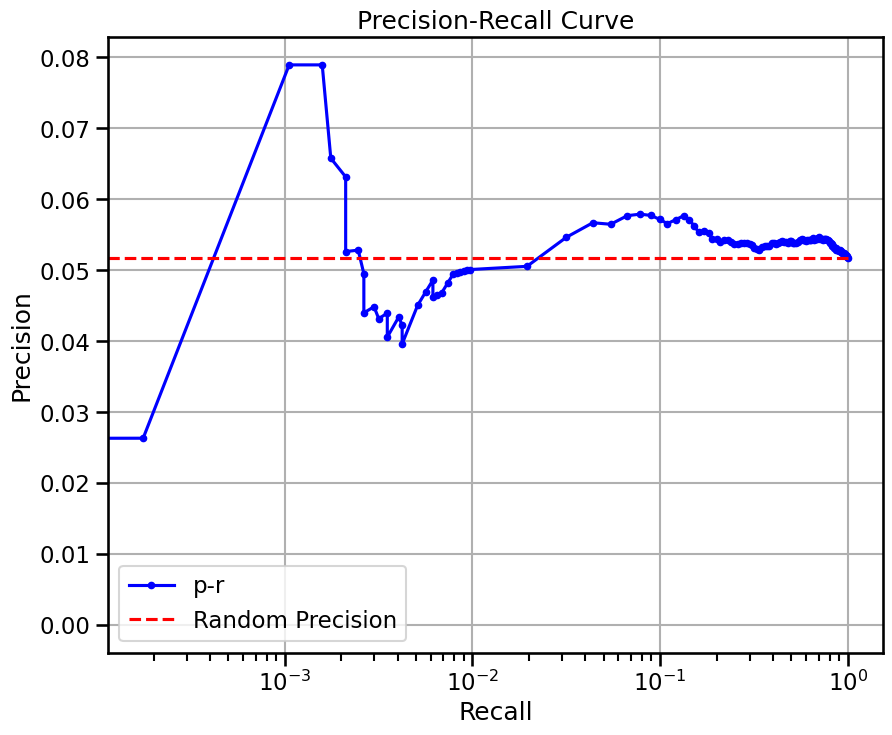

{'precision': 0.051739843323009654,
 'recall': 1.0,
 'rand_precision': 0.05175021410739992,
 'auprc': 0.0540876874680279,
 'epr': 1.1382737356974408}

In [49]:
grn.varp["GRN"] = clf_self.predict_proba(
                    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
                ).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 8220


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

precision:  0.051739843323009654 
recall:  1.0 
random precision: 0.05175021410739992


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:721: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1681.13it/s]


Area Under Precision-Recall Curve (AUPRC):  0.039042565007002546
EPR: 0.18385330432131444


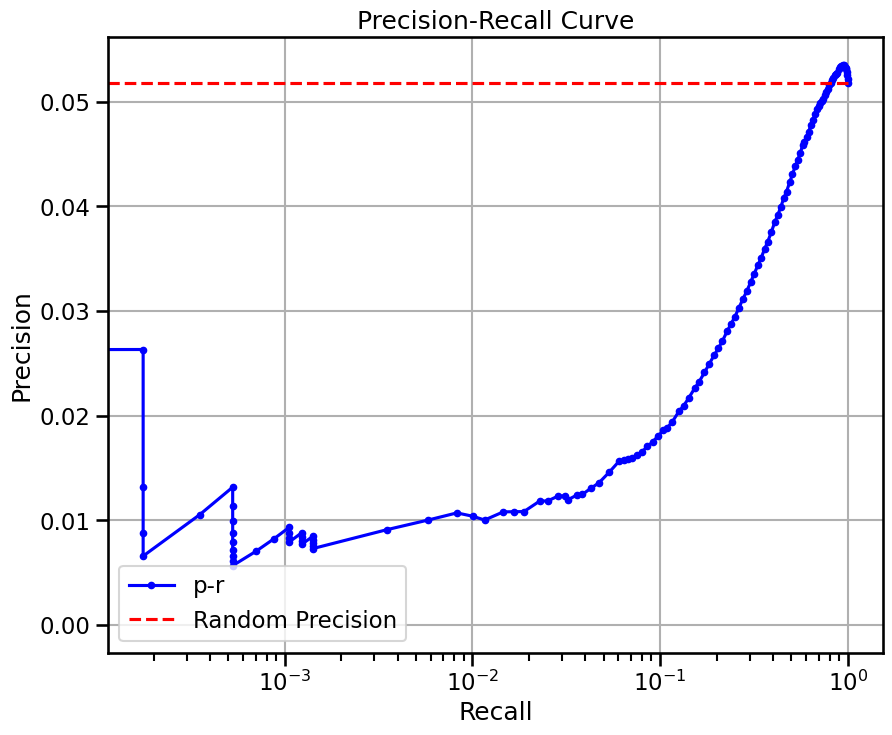

precision:  0.051739843323009654 
recall:  1.0 
random precision: 0.05175021410739992


 79%|███████▉  | 101/128 [00:00<00:00, 1009.24it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:721: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1065.39it/s]


Area Under Precision-Recall Curve (AUPRC):  0.06913422478105277
EPR: 1.0381999805130386


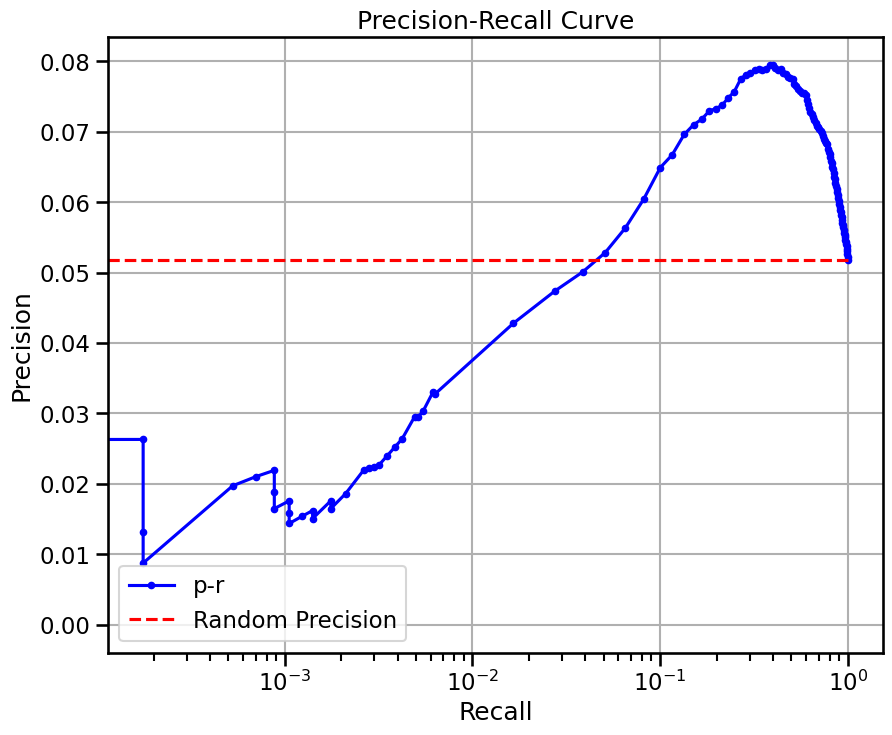

precision:  0.051739843323009654 
recall:  1.0 
random precision: 0.05175021410739992


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:721: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1539.34it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0540876874680279
EPR: 1.1382737356974408


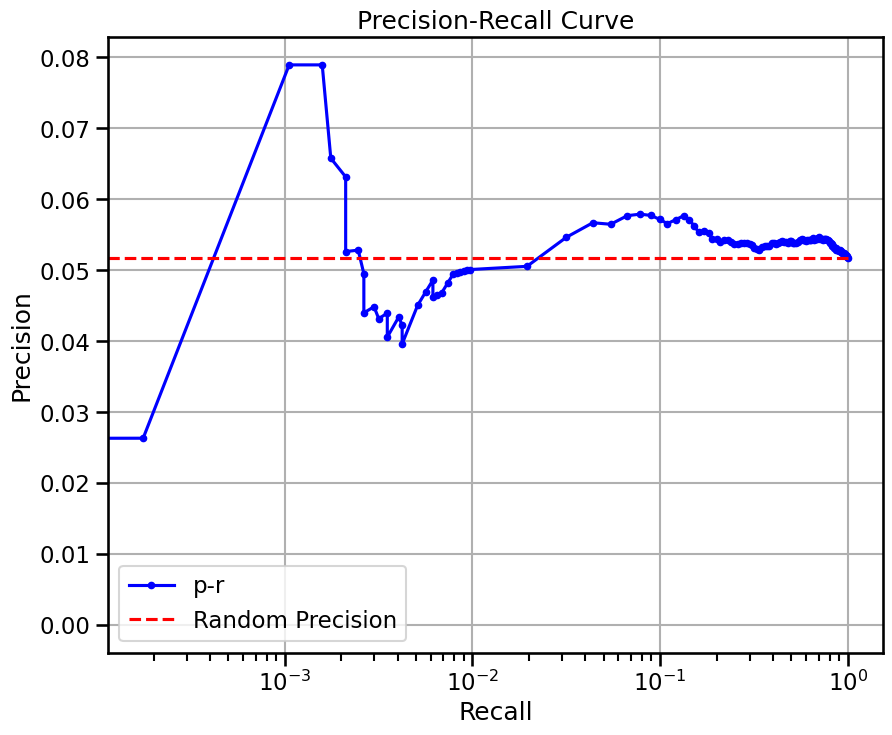

AttributeError: 'dict' object has no attribute 'T'

In [37]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=1024,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])

grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['all'].mean(-1).T
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)
grn.varp["GRN"] = clf_omni.predict_proba(
                    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
                ).reshape(len(grn.var), len(grn.var), 2)[:, :, 1].T
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)
#grn.var.index = grn.var['ensembl_id']
grn.varp["GRN"] = clf_self.predict_proba(
                    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
                ).reshape(len(grn.var), len(grn.var), 2)[:, :, 1].T
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

## WOWOWOWOWO

precision:  0.040534915985817786 
recall:  1.0 
random precision: 0.0405430408437023


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:720: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 1727.04it/s]


Area Under Precision-Recall Curve (AUPRC):  0.06868116613952381
EPR: 1.3494427146334347


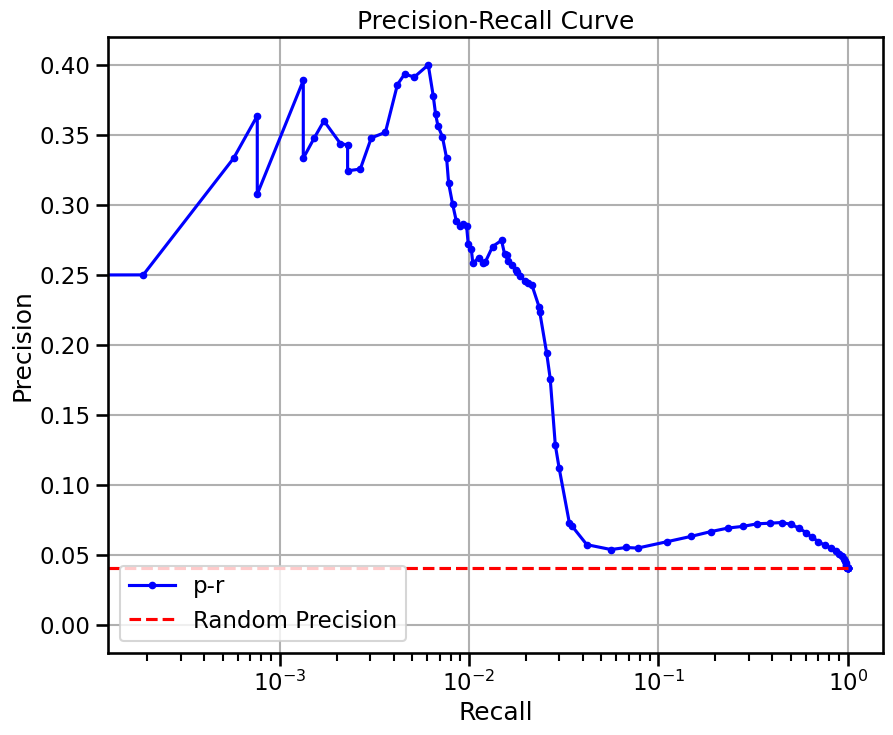

{'precision': 0.040534915985817786,
 'recall': 1.0,
 'rand_precision': 0.0405430408437023,
 'auprc': 0.06868116613952381,
 'epr': 1.3494427146334347}

In [ ]:
grn.varp["GRN"] = grn.varp['all'][:,:,:].max(-1).T
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.040534915985817786 
recall:  1.0 
random precision: 0.0405430408437023


 83%|████████▎ | 82/99 [00:00<00:00, 816.70it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:720: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 793.07it/s]


Area Under Precision-Recall Curve (AUPRC):  0.04219116968940259
EPR: 0.9684091857978684


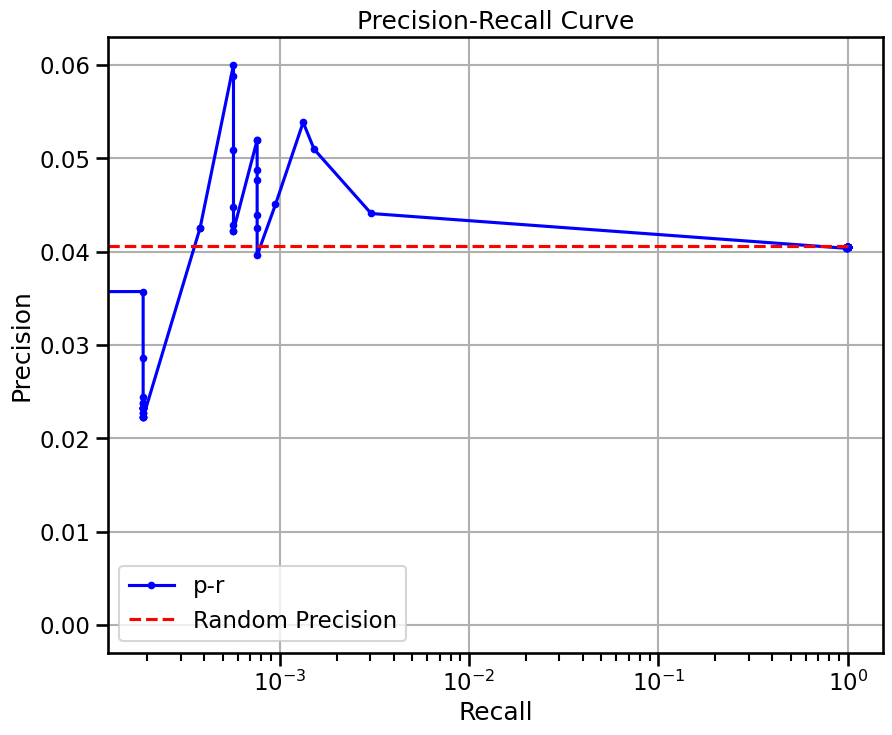

{'precision': 0.040534915985817786,
 'recall': 1.0,
 'rand_precision': 0.0405430408437023,
 'auprc': 0.04219116968940259,
 'epr': 0.9684091857978684}

In [ ]:
grn.varp["GRN"] = clf_self.predict_proba(
                    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
                ).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)